# 映画レビューデータの総合傾向分析

本ノートブックでは、独自に生成したダミーのレビューデータを用いて、統計的分析、時系列分析、およびネタバレの有無によるテキストマイニングを統合的に行います。

## 0. 準備：ライブラリのインストール
日本語表示と形態素解析のために必要なライブラリをインストールします。

In [1]:
!pip install japanize-matplotlib janome

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 41.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 72.5 MB/s eta 0:00:00
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=1c725007203dd77614d934857a8c3b1beb30b9a41f70dbeb2fd7763ba117a90e
  Stored in directory: /root/.cache/pip/wheels/c1/f7/9b/418f19a7b9340fc16e071e89efc379aca68d40238b258df53d
Successfully built japanize-matplotlib


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from janome.tokenizer import Tokenizer
from collections import Counter

# グラフのスタイル設定
sns.set(font="IPAexGothic")

## 1. データの読み込みとクリーニング

In [3]:
df = pd.read_csv('dummy_reviews.csv')

# 星評価の数値化と欠損値処理
df['星評価'] = pd.to_numeric(df['星評価'], errors='coerce')
df = df.dropna(subset=['星評価'])

# 日付の変換
df['投稿日'] = pd.to_datetime(df['投稿日'])

print(f"有効なデータ件数: {len(df)}件")
df.head()

有効なデータ件数: 176件


,投稿者,投稿日,星評価,ネタバレ,口コミ全文
0,user_4329,2025-02-03 16:00:00,4.0,なし,ストーリーが少し難解でした。
1,user_7942,2025-02-21 14:00:00,2.3,あり,伏線の回収がすごかった！
2,user_2650,2025-03-03 02:00:00,3.6,あり,伏線の回収がすごかった！
3,user_7266,2025-05-20 01:00:00,4.7,なし,泣けました。感動です。
4,user_4578,2025-04-25 04:00:00,2.9,あり,ストーリーが少し難解でした。


## 2. 統計的な可視化（星評価の分布）

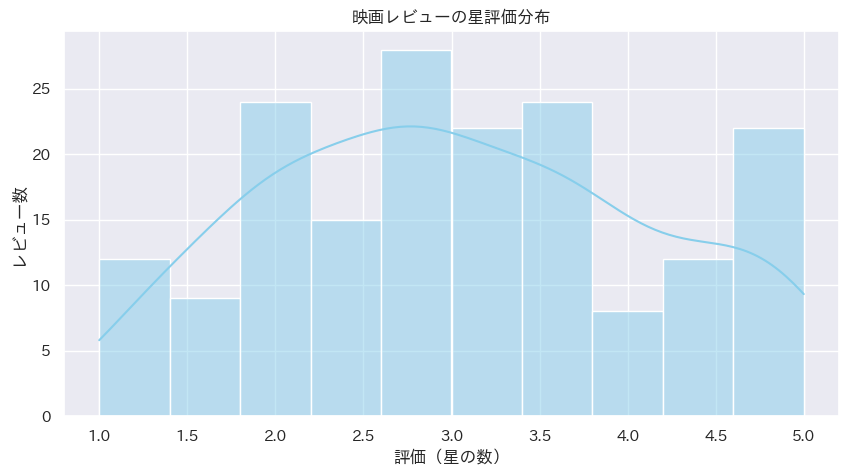

In [4]:
plt.figure(figsize=(10, 5))
sns.histplot(df['星評価'], bins=10, kde=True, color='skyblue')
plt.title('映画レビューの星評価分布')
plt.xlabel('評価（星の数）')
plt.ylabel('レビュー数')
plt.show()

## 3. 時系列分析（投稿数の推移）

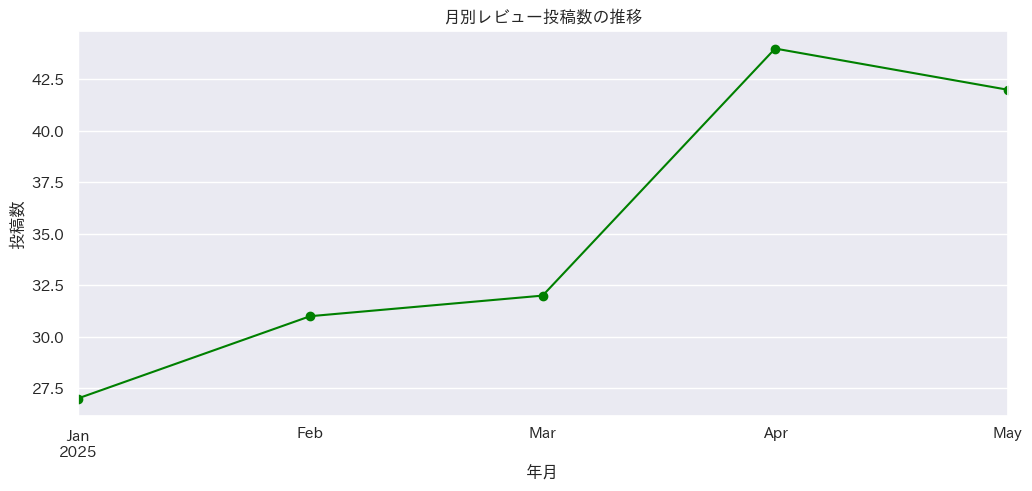

In [5]:
df['月'] = df['投稿日'].dt.to_period('M')
monthly_counts = df.groupby('月').size()

plt.figure(figsize=(12, 5))
monthly_counts.plot(kind='line', marker='o', color='green')
plt.title('月別レビュー投稿数の推移')
plt.xlabel('年月')
plt.ylabel('投稿数')
plt.grid(True)
plt.show()

## 4. ネタバレあり・なしの件数比較

/tmp/ipython-input-1577277173.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='ネタバレ', data=df, palette='pastel', order=['あり', 'なし'])


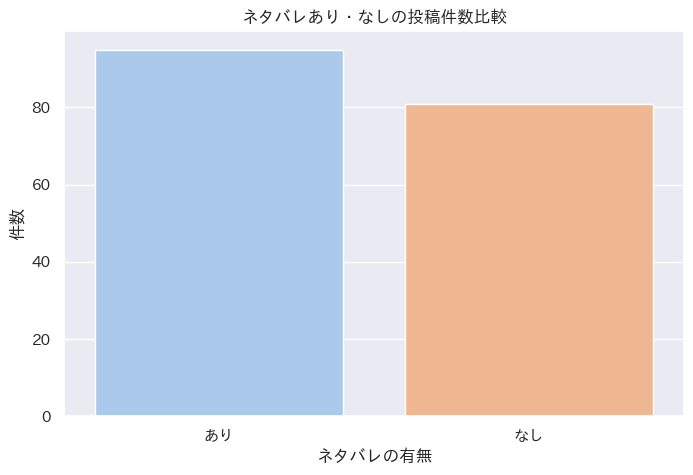

In [6]:
plt.figure(figsize=(8, 5))
sns.countplot(x='ネタバレ', data=df, palette='pastel', order=['あり', 'なし'])
plt.title('ネタバレあり・なしの投稿件数比較')
plt.xlabel('ネタバレの有無')
plt.ylabel('件数')
plt.show()

## 5. ネタバレ別の頻出単語分析（テキストマイニング）

/tmp/ipython-input-4268419115.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='回数', y='単語', data=df_yes, ax=ax1, palette='Reds_r')
/tmp/ipython-input-4268419115.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='回数', y='単語', data=df_no, ax=ax2, palette='Blues_r')


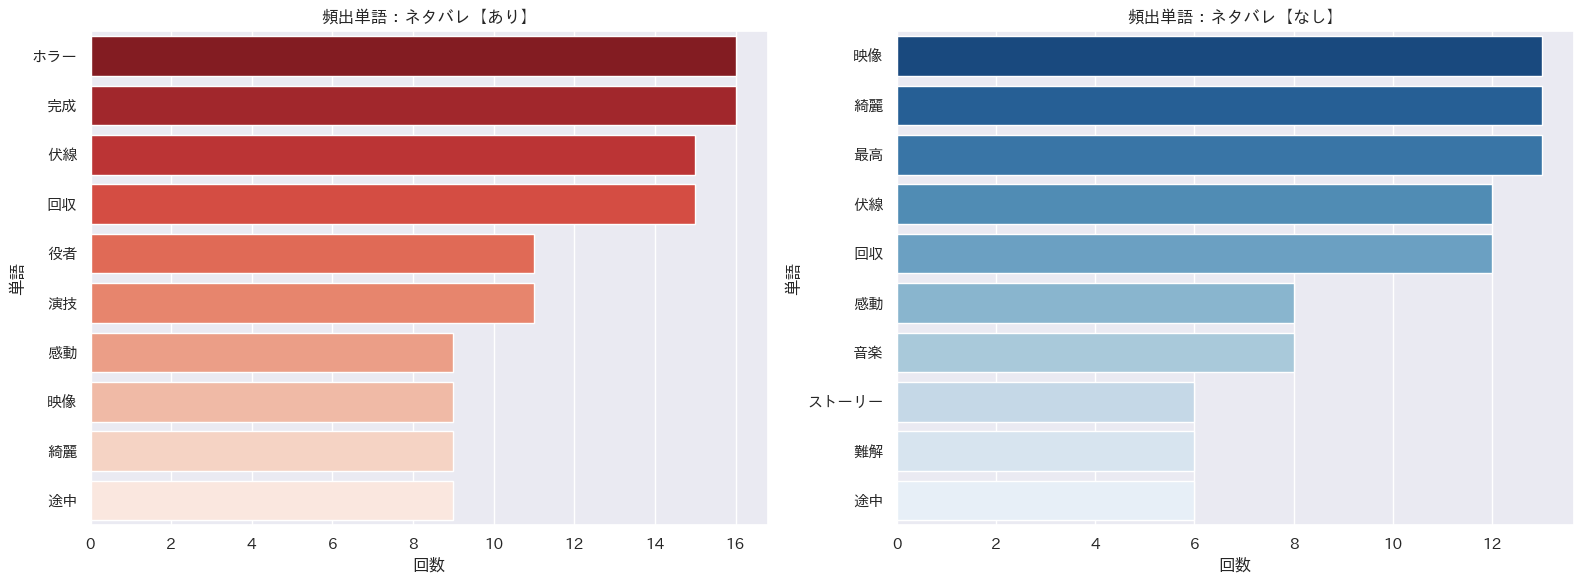

In [7]:
t = Tokenizer()

def get_frequent_words(texts, top_n=10):
    words = []
    for text in texts:
        tokens = t.tokenize(text)
        for token in tokens:
            pos = token.part_of_speech.split(',')[0]
            if pos == '名詞' and len(token.surface) > 1:
                words.append(token.surface)
    return Counter(words).most_common(top_n)

spoiler_yes_texts = df[df['ネタバレ'] == 'あり']['口コミ全文']
spoiler_no_texts = df[df['ネタバレ'] == 'なし']['口コミ全文']

common_yes = get_frequent_words(spoiler_yes_texts)
common_no = get_frequent_words(spoiler_no_texts)

df_yes = pd.DataFrame(common_yes, columns=['単語', '回数'])
df_no = pd.DataFrame(common_no, columns=['単語', '回数'])

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
sns.barplot(x='回数', y='単語', data=df_yes, ax=ax1, palette='Reds_r')
ax1.set_title('頻出単語：ネタバレ【あり】')
sns.barplot(x='回数', y='単語', data=df_no, ax=ax2, palette='Blues_r')
ax2.set_title('頻出単語：ネタバレ【なし】')
plt.tight_layout()
plt.show()

## 6. 分析結果

- 統計、時系列、テキストの三側面からレビューデータを分析しました。
- ネタバレの有無という属性で切り分けることで、ユーザーの投稿動機の違いを可視化することができました。